<h1><p align = 'center'> <strong >Olá<br></strong>Use o ambiente "raspilum" (Python 3.10.18)</h4></p>


<h5>Devido a organização das pastas, uso as bibliotecas "os" e "sys" para definidir o local como sendo na pasta anterior, a "Controle_jubilee"</h5>

In [51]:
import sys
import os
sys.path.append(os.path.abspath(".."))

<h5> Em seguida, faço a importação os objetos e funções dos scripts Python. Recomendo que acesse esses arquivo .py para conferir melhor os métodos das classes que representam o sistema</h5>

In [52]:
from jubilee_controller import JubileeMotionController
import matplotlib.pyplot as plt
import time
import numpy as np 
from pynput import keyboard
import cv2
from datetime import datetime
from camera_controller import camera_tool
from email_sender import send_email
from image_processing import detect_circle
from gripper_controller import Gripper

<h5> Nas duas células a seguir, defino a instância da classe JubileeMotionController e faço um reset da máquina. O reset não é necessário sempre, rode essa células apenas se algum motor não responder durante a calibração.</h5>

In [53]:
jubilee = JubileeMotionController()

In [54]:
jubilee.reset()

Reconectando...


<h5> <P align='justify'>Para  calibrar a máquina, basta usar o método "home_all", ele é responsável por calibrar todos os eixos da máquina. Ao rodar a célula a seguir, a máquina vai calibrar o eixo y e x voltando a guia linear até encontrar o sensor de fim de curso. Em seguida, ele vai abrir uma janela perguntando se a mesa está livre e vai fazer a calibração do z. Ressalto que o modo mesh_mode_z serve para fazer ou não o alinhamento da mesa, geralmente não é necessário fazer, a menos que, esteja visivelmente desalinhada. Após o alinhamento do z, o do sistema de troca de ferramentas é calibrados. O método protect_tools impede que o sistema avance em valores menores que 50 no eixo y, o que impede colisões com as ferramentas. Esse método é desativado de forma temporaria e automática durante a instalação de ferramentas. </p></h5>

In [62]:
jubilee.home_all(mesh_mode_z=False)
jubilee.protect_tools(on=True)
jubilee.move_xyz_absolute(z=50)

<h5>
<p align='justify'>
Você pode usar os métodos move_xyz_absolute e move_xyz_relative para controlar a posição do sistema. No modo absoluto, cada coordenada representa a posição global da plataforma, ou seja, a máquina se move exatamente para a posição especificada no espaço. Já no modo relativo, os movimentos são calculados a partir da posição atual, então, por exemplo, um comando como (10, 0, -20) fará com que a plataforma se desloque 10 mm para a direita em X e suba 20 mm em Z a partir da posição atual. A imagem a seguir mostra o sistema na posição (0, 50, 0).
</p>
</h5>

<p align="center">
  <img src="https://raw.githubusercontent.com/jsales-1/raspilum_jubilee/main/Imagens%20Readme/sentidos_jubilee.jpg" width="400"><br>
  <em>Exemplo da plataforma na posição (0,50,0).</em>
</p>





<h5>
<p align='justify'>
A célula a seguir faz é um exemplo de movimentação absoluta. Rodando a célula com essa coordenadas, o suporte de ferramentas vai para o canto superior direito e abaixará a plataforma. Considerando que se trata de um posição absoluta, ao rodar a célula duas vezes, sem que outra movimentação tenha sido feita, nada acontecerá, pois a máquina se encontrará na posição definida anteriormente.
</p>

In [57]:
jubilee.move_xyz_absolute(x=320,y=390,z=200,velocity=6000)

<h5>
<p align='justify'>
É possível colocar <i>delays</i> nas movimentações usando o método sleep da biblioteca <i>time</i> para fazer com que a máquina passe um tempo parado após cada movimentação. Esse método recebe o tempo de espera em segundos.
</p>

In [58]:
jubilee.move_xyz_absolute(x=165,y=200,z=200,velocity=6000)
time.sleep(4)
jubilee.move_xyz_absolute(x=0,y=300,z=250,velocity=6000)
time.sleep(5)
jubilee.move_xyz_absolute(x=165,y=200,z=200,velocity=6000)

<h5>
<p align='justify'>
A próxima célula é um exemplo de movimentação relativa, ao rodar, a máquina irá se movimentar em 100mm no eixo x e depois irá retornar menos 100mm, voltando para a posição inicial. Observe que a velocidade de movimento também pode ser definida. A unidade da velocidade está em mm/min, não se preocupe caso venha a definir uma velocidade de 17987547480000mm/min por acidente, a velocidade máxima de XY são definidos como 18000mm/min nas configurações da máquina, enquanto Z tem por velocidade máxima 1600mm/min.
</p>

In [74]:
jubilee.move_xyz_relative(x=100,y=0,z=0,velocity=1500)
time.sleep(1)
jubilee.move_xyz_relative(x=-100,y=0,z=0,velocity=1500)

<h5>
<p align='justify'>
É possível fazer loops de movimentação, permitindo que a máquina fique fazendo movimentações repetitivas. A pŕoxima célula faz com que a máquina faça 5 vezes o perímetro de um retangulo.
</p>

In [75]:
for _ in range(5):
    jubilee.move_xyz_absolute(x=165,y=200,z=200,velocity=10000)
    jubilee.move_xyz_absolute(x=65,y=200,z=200,velocity=10000)
    jubilee.move_xyz_absolute(x=65,y=350,z=200,velocity=10000)
    jubilee.move_xyz_absolute(x=165,y=350,z=200,velocity=10000)


<h5>
<p align='justify'>Utilizando das funções trigonométricas disponíveis do numpy, pode-se criar movimentações mais complexas, como circunferências 
</p>

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


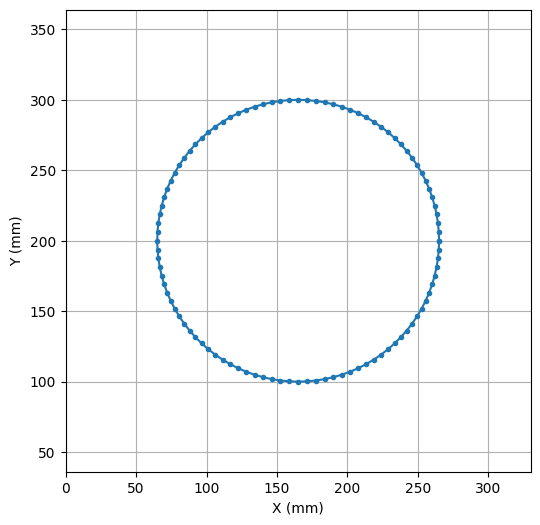

In [76]:
xc = 165
yc = 200
R = 100  
z = 200
velocidade = 10000

n_pontos = 100

for i in range(n_pontos + 1):
    theta = 2 * np.pi * i / n_pontos
    x = xc + R * np.cos(theta)
    y = yc + R * np.sin(theta)
    jubilee.move_xyz_absolute(x=x, y=y, z=z, velocity=velocidade)

theta = np.linspace(0, 2 * np.pi, n_pontos + 1)
x = xc + R * np.cos(theta)
y = yc + R * np.sin(theta)

plt.figure(figsize=(6, 6))
plt.plot(x, y, '-o', markersize=3)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.axis("equal")
plt.xlim((0,330))
plt.ylim((0,400))
plt.grid(True)
plt.show()


<h5>
<p align='justify'>
O método keyboard_controll permite controlar o sistema diretamente pelo teclado. As setas direcionais movimentam a plataforma: a seta para cima move em Y para frente, a seta para baixo move em Y para trás, a seta para a esquerda move em X para a esquerda e a seta para a direita move em X para a direita. As teclas "Page Up" e "Page Down" movimentam a plataforma para cima e para baixo no eixo Z. Com as teclas + e - você pode aumentar ou diminuir o tamanho do passo, que determina a distância percorrida em cada movimento. Para encerrar o controle pelo teclado, basta pressionar a tecla "esc" ou interromper a célula. Durante o uso, a posição atual da plataforma e o passo configurado são exibidos em tempo real no console.
</p>
</h5>

In [48]:
jubilee.keyboard_controll()

X:  185.00 | Y:  190.00 | Z:  200.00 || Passo: 10  mm
Interrompido
